<a href="https://colab.research.google.com/github/UdeS-PMF/gmq710_test/blob/develop/Signs_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification de panneau de circulation

## Objectifs

Utiliser Keras pour faire un outil de reconnaissance des panneaux de circulation.

On va utiliser une base d'exemples annotés. On va créer un réseau de neurones et l'entraîner sur les images.

## Principe

On va entraîner un réseau sur un ensemble de données (panneaux de circulation). On va créer une catégorie pour chaque panneau.

On décompresse l'ensemble de données (obtenir les données : https://drive.google.com/file/d/1ZUO_j1rxoJ3nT4ZlJ5aocuqYQUfaMbio/view?usp=sharing)

In [ ]:
!unzip /content/signs.zip

Archive:  /content/signs.zip
  inflating: annotations/road0.xml   
  inflating: annotations/road1.xml   
  inflating: annotations/road10.xml  
  inflating: annotations/road100.xml  
  inflating: annotations/road101.xml  
  inflating: annotations/road102.xml  
  inflating: annotations/road103.xml  
  inflating: annotations/road104.xml  
  inflating: annotations/road105.xml  
  inflating: annotations/road106.xml  
  inflating: annotations/road107.xml  
  inflating: annotations/road108.xml  
  inflating: annotations/road109.xml  
  inflating: annotations/road11.xml  
  inflating: annotations/road110.xml  
  inflating: annotations/road111.xml  
  inflating: annotations/road112.xml  
  inflating: annotations/road113.xml  
  inflating: annotations/road114.xml  
  inflating: annotations/road115.xml  
  inflating: annotations/road116.xml  
  inflating: annotations/road117.xml  
  inflating: annotations/road118.xml  
  inflating: annotations/road119.xml  
  inflating: annotations/road12.xml  
 

On importe les libs utiles

In [ ]:
import numpy as np
from PIL import Image
import os

import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

Visualisation du jeu de données

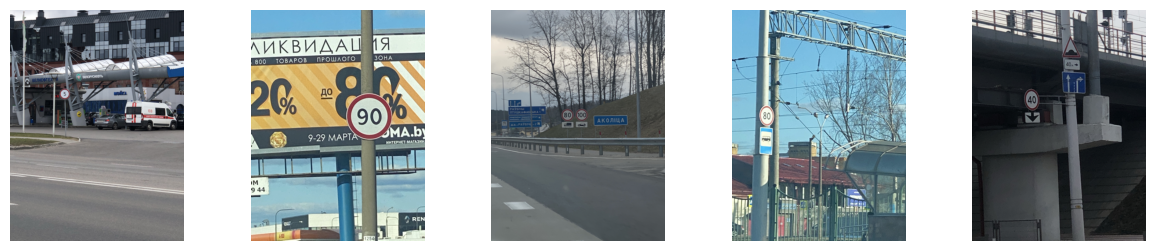

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Définir le chemin du répertoire contenant les images
directory_path = '/content/images'

# Liste des fichiers d'images dans le répertoire
image_files = [f for f in os.listdir(directory_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Sélectionner 5 images aléatoires
selected_images = random.sample(image_files, 5)

# Afficher les images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, image_file in enumerate(selected_images):
    # Chemin complet de l'image
    image_path = os.path.join(directory_path, image_file)

    # Charger et afficher l'image
    image = mpimg.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

# Afficher les images sélectionnées
plt.show()


On va constituer un jeu d'entrainement à partir des images annotées.

In [ ]:
# on peut découper la zone exacte où le panneau apparaît
# on définit une fonction
def crop_objects_as_numpy(image_path, bboxes):
    # Ouvrir l'image
    image = Image.open(image_path)
    image = image.convert('RGB')
    # Initialiser une liste pour stocker les matrices numpy des régions extraites
    cropped_regions = []

    # Parcourir chaque bounding box et label
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox

        # Extraire la région de l'image en fonction de la bounding box
        object_region = image.crop((xmin, ymin, xmax, ymax))
        object_region = object_region.resize((124,124))
        # Convertir la région extraite en une matrice numpy
        object_np = np.array(object_region)

        # Ajouter la matrice numpy à la liste
        cropped_regions.append(object_np)

    return cropped_regions

# on peut lire le fichier xml d'annotations permettant de connaître
# les objets présents dans l'image et leur position
def parse_xml_with_bounding_boxes(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Récupérer le chemin de l'image
    image_path = os.path.join(images_dir, root.find('filename').text)

    # Récupérer les labels
    labels = [obj.find('name').text for obj in root.findall('.//object')]

    # Récupérer les bounding boxes
    bboxes = []
    for obj in root.findall('.//object'):
        bbox = [int(obj.find('bndbox/xmin').text),
                int(obj.find('bndbox/ymin').text),
                int(obj.find('bndbox/xmax').text),
                int(obj.find('bndbox/ymax').text)]
        bboxes.append(bbox)

    return image_path, labels, bboxes


# Chemin vers le répertoire contenant les annotations XML
annotations_dir = '/content/annotations'

# Chemin vers le répertoire contenant les images PNG
images_dir = '/content/images'

# Liste pour stocker les fichiers XML avec des erreurs
xml_files_with_errors = []

# Liste pour stocker les chemins des images et les labels correspondants
images_list = []
labels_list = []

# Parcourir tous les fichiers XML
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        try:
            # Analyser le fichier XML
            image_path, labels, bboxes = parse_xml_with_bounding_boxes(os.path.join(annotations_dir, xml_file))

            cropped_regions = crop_objects_as_numpy(image_path, bboxes)
            for label, region_np in zip(labels, cropped_regions):

                images_list.append(region_np)
                labels_list.append(label)
            # Ajouter le chemin de l'image et les labels aux listes
            #image_paths.append(image_path)
            #labels_list.append(labels)

        except Exception as e:
            print(f"Erreur lors de l'analyse de {xml_file}: {str(e)}")
            xml_files_with_errors.append(xml_file)

print("Listes créées avec succès.")
print("Images:", len(images_list))
print("Labels:", len(labels_list))


# Afficher les fichiers XML avec des erreurs
if xml_files_with_errors:
    print("\nFichiers XML avec des erreurs:", xml_files_with_errors)


Listes créées avec succès.
Images: 1244
Labels: 1244


On convertit en 2 vecteurs

In [ ]:
data = np.array(images_list)
labels = np.array(labels_list)

In [ ]:
print(data.shape, labels.shape)

(1244, 124, 124, 3) (1244,)


On doit convertir les étiquettes en catégorie numérique

In [ ]:
# Utiliser LabelEncoder pour convertir les chaînes de texte en entiers
label_encoder = LabelEncoder()
labels_enc = label_encoder.fit_transform(labels)

# Utiliser to_categorical pour obtenir la représentation one-hot encoding
nb_classes = len(set(labels_enc))
num_labels = to_categorical(labels_enc, num_classes=nb_classes)

# affichage
print(num_labels)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


On va créer 2 jeux de données (entrainement et test)

In [ ]:
# idéalement on sépare en 2 jeux : 1 pour l'entraînement et 1 pour les tests
X_t1, X_t2, y_t1, y_t2 = train_test_split(data, num_labels, test_size=0.2, random_state=42)
print(X_t1.shape, X_t2.shape, y_t1.shape, y_t2.shape)

(995, 124, 124, 3) (249, 124, 124, 3) (995, 4) (249, 4)


On construit le modèle

In [ ]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nb_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


On entraine le modèle (selon le type de processeur, cela peut prendre du temps, utilisez un GPU)

In [ ]:
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
eps = 50
anc = model.fit(X_t1, y_t1, batch_size=32, epochs=eps, validation_data=(X_t2, y_t2))


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.5064 - loss: 80.3580 - val_accuracy: 0.7791 - val_loss: 0.8506
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7241 - loss: 0.9340 - val_accuracy: 0.7430 - val_loss: 0.7713
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8088 - loss: 0.6353 - val_accuracy: 0.7912 - val_loss: 0.5807
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8020 - loss: 0.5856 - val_accuracy: 0.8554 - val_loss: 0.4277
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8783 - loss: 0.3919 - val_accuracy: 0.9277 - val_loss: 0.2378
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9045 - loss: 0.2629 - val_accuracy: 0.9317 - val_loss: 0.3515
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9621 - loss: 0.1431 - val_accuracy: 0.9679 - val_loss: 0.1686
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9705 - loss: 0.1072 - val_accuracy: 0.9317 

On évalue les résultats

In [ ]:
# Évaluation du modèle avec le jeu de test
evaluation_results = model.evaluate(X_t2, y_t2)

# Affichage des résultats
print("Loss on test set:", evaluation_results[0])
print("Accuracy on test set:", evaluation_results[1])


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9530 - loss: 0.3934
Loss on test set: 0.3231157660484314
Accuracy on test set: 0.9718875288963318


On peut vérifier quelques images du jeu de tests

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


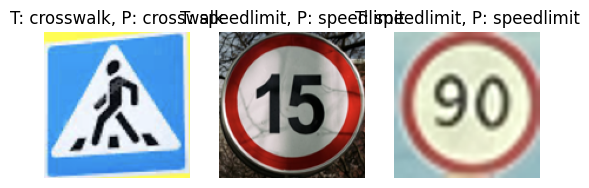

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtenez les prédictions pour le jeu de test
predictions = model.predict(X_t2)

# Sélectionnez quelques exemples aléatoires à afficher
num_examples_to_display = 3
random_indices = np.random.choice(len(X_t2), num_examples_to_display, replace=False)
true_labels_decoded = label_encoder.inverse_transform(np.argmax(y_t2, axis=1))
predicted_labels_decoded = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Affichez les images avec les labels prédits
for i, index in enumerate(random_indices):
    # Récupérez l'image
    image = X_t2[index]

    # Récupérez le label réel et le label prédit
    #print(label_encoder.inverse_transform(y_t2[index]))
    # Récupérez le label réel et le label prédit
    true_label = true_labels_decoded[index]
    predicted_label = predicted_labels_decoded[index]

    # Affichez l'image avec le label réel et le label prédit
    plt.subplot(1, num_examples_to_display, i+1)
    plt.imshow(image)
    plt.title(f'T: {true_label}, P: {predicted_label}')
    plt.axis('off')

plt.show()


Si on souhaite conserver le réseau

In [ ]:
model.save("/content/signs_model.h5")

On peut tester une image sur le web

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


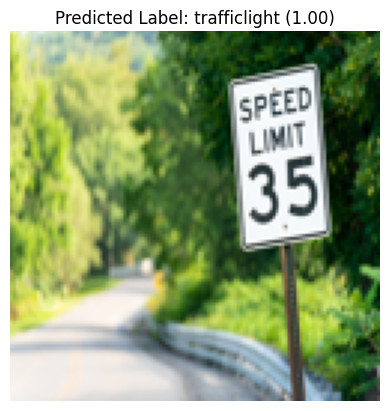

In [ ]:
import requests
from PIL import Image
import numpy as np

# URL de l'image du web que vous souhaitez tester
image_url = 'https://t3.ftcdn.net/jpg/06/20/90/96/360_F_620909699_oNlTPcuh7BxEYvkXY5mnTo8TUcKokZ4r.jpg'

# Télécharger l'image depuis le web
response = requests.get(image_url, stream=True)
response.raise_for_status()

# Ouvrir l'image avec PIL
image = Image.open(response.raw).convert('RGB')

# Prétraitement de l'image (assurez-vous que le prétraitement est conforme à ce que vous avez fait pour les données d'entraînement)
# Exemple : redimensionnement de l'image à la taille attendue
image = image.resize((124, 124))  # Remplacez width et height par les dimensions attendues par votre modèle

# Convertir l'image en tableau NumPy
image_array = np.array(image)

# Ajouter une dimension supplémentaire pour créer un lot (batch) d'une seule image
image_array_batch = np.expand_dims(image_array, axis=0)

# charger le fichier h5
model = load_model("/content/signs_model.h5")

# Faire des prédictions avec le modèle
predictions = model.predict(image_array_batch)

predicted_label = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]

# Récupérer les probabilités de prédiction associées à chaque classe
class_probabilities = predictions[0]

# Trouver l'indice de la classe prédite dans label_encoder.classes_
predicted_label_index = np.where(label_encoder.classes_ == predicted_label)[0][0]

# Extraire la probabilité associée à la classe prédite
predicted_class_probability = class_probabilities[predicted_label_index]


# Afficher l'image
plt.imshow(image_array)
plt.title(f"Predicted Label: {predicted_label} ({predicted_class_probability:.2f})")
plt.axis('off')
plt.show()
